# MLP（回帰）を実装しながらpytorchを基礎から学ぶ

PyTorchはfacebookが開発した急速に成長しているディープラーニングフレームワークです。もともとはchainerのforkでしたが、先行して欧米圏の研究者に広く普及したことから、現在はPFN側がchainerを中止し、pytorchの開発に協力・合流する形となりました。
pytorchがどのように機能するかを実装しながら確認したいと思います。

流れ  
・ニューラルネットワークの定義（nn.Module）  
・入力データセットの反復処理（Dataset, Dataloader）    
・損失の計算、勾配をネットワークのパラメーターに伝播（nn.Module）  
・ネットワークの重みを更新（optimaizer）

モジュール   
torch.Tensor- backward()などのautograd操作をサポートする多次元配列。テンソルに対する勾配も保持します   
nn.Module-ニューラルネットワークモジュール。GPUへの移動、エクスポート、読み込みなどのヘルパーを使用して、パラメーターをカプセル化する便利な方法  
nn.Parameter-テンソルの一種。これは、属性としてに割り当てられたときにパラメータとして自動的に登録されます  
autograd.Function-autograd操作の前方および後方定義を実装します。すべてのTensor操作は、Functionを作成しTensor、その履歴をエンコードする関数に接続する少なくとも1つのノードを作成します  

## データの作成

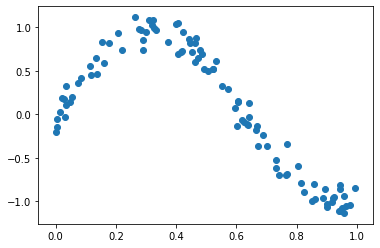

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12)
x = np.random.rand(100, 1)
y = np.sin(5*x) + 0.1*np.random.randn(100, 1)

plt.scatter(x, y)

## tensor化
deep learningでは計算にtensorが使われる。tensorとは3次元以上の配列のこと（scalarは0次元、vectorは1次元、matrixは2次元配列）
numpy arrayをpytochに渡すにはtensorにする必要がある。
torch.FloatTensorは32bit浮動小数点のこと（tensor属性について：https://pytorch.org/docs/stable/tensor_attributes.html）

In [2]:
import torch

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

print(type(x), type(x_tensor), x_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


## モデルの定義

pytorchでは、nn.Moduleクラスを継承した「pythonのclass」としてモデルを定義する

class MLP(nn.Module):
定義するMLPというclassは、親クラスnn.Moduleを継承

def __init__(self, n_feature=1, n_hidden=1, n_output=1)：
引数を受け取ってインスタンス化する

super(MLP, self).__init__()：
nn.Moduleを継承して定義するためsuper関数を使う

def forward(self, x):
forward関数を定義するとbackward 関数（勾配が計算される）も自動的に定義される

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# modelの定義
class MLP(nn.Module):
    def __init__(self, n_feature=1, n_hidden=1, n_output=1):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(n_feature, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.hidden3(x)
        return x

net = MLP(n_hidden=3)
print(net)

params = list(net.parameters())
print(len(params))
print(params[0].size())

MLP(
  (hidden1): Linear(in_features=1, out_features=3, bias=True)
  (hidden2): Linear(in_features=3, out_features=3, bias=True)
  (hidden3): Linear(in_features=3, out_features=1, bias=True)
)
6
torch.Size([3, 1])


## 損失の計算

In [4]:
# xを入力してみる
x1 = x_tensor[0]
output = net(x1)

print('output:{}'.format(output))

# 出力に対して損失を計算する
y1 = y_tensor[0]

loss_func = nn.MSELoss()
loss = loss_func(output, y1)

print(loss)

output:tensor([0.1793], grad_fn=<AddBackward0>)
tensor(0.4332, grad_fn=<MseLossBackward>)


## 誤差逆伝播
逆伝播のステップはgrad_fnで確認できる

In [5]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) 

loss.backward()を使用して、誤差を逆伝播する。
その前に既存の勾配があると蓄積されてしまうため、net.zero_grad()で消去する必要がある。

In [6]:
net.zero_grad()
print(net.hidden1.bias.grad)

loss.backward(retain_graph=True)
print(net.hidden1.bias.grad)

None
tensor([ 0.0234, -0.2951,  0.0000])


## 重みの更新
確率的勾配降下法（SGD）、Nesterov-SGD、Adam、RMSPropなどのさまざまなをtorch.optimで実装できる。

In [7]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad()
print(net.hidden1.weight)
print(net.hidden1.bias.grad)

output = net(x1)
loss = loss_func(output, y1)
loss.backward()
optimizer.step()  # 重みを更新

print(net.hidden1.weight)
print(net.hidden1.bias.grad)

Parameter containing:
tensor([[-0.7350],
        [ 0.6190],
        [-0.6888]], requires_grad=True)
tensor([0., 0., 0.])
Parameter containing:
tensor([[-0.7350],
        [ 0.6194],
        [-0.6888]], requires_grad=True)
tensor([ 0.0234, -0.2951,  0.0000])


In [8]:
## 学習ループを回す

Dataset：データとそれに対応するラベルを1組返すモジュール
DataLoader：データをバッチサイズにまとめて返すモジュール

In [9]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

x_tensor = torch.from_numpy(x).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)
print(x_tensor.type())

dataset = TensorDataset(x_tensor, y_tensor)
print(dataset[0])

train, val = random_split(dataset, [80, 20])
train_loader = DataLoader(dataset=train, batch_size=20)
val_loader = DataLoader(dataset=val, batch_size=20)

torch.cuda.FloatTensor
(tensor([0.1542], device='cuda:0'), tensor([0.8375], device='cuda:0'))


In [10]:
model = MLP(n_hidden=100).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=1e-1)
#train_step = make_train_step(model, loss_fn, optimizer)

n_epochs = 100
training_losses = []
validation_losses = []
# print(model.state_dict())

for epoch in range(n_epochs):
    batch_losses = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        model.train()
        y_pred = model(x_batch)
        loss = loss_fn(y_batch, y_pred)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_losses.append(loss.item())
        
    training_loss = np.mean(batch_losses)
    training_losses.append(training_loss)

    with torch.no_grad():
        val_losses = []
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()
            y_pred = model(x_val)
            val_loss = loss_fn(y_val, y_pred).item()
            val_losses.append(val_loss)
            
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)
    
    if (epoch+1) % 20 == 0:
        print(f"[{epoch+1}] Training loss: {training_loss:.3f}\t Validation loss: {validation_loss:.3f}")

# print(model.state_dict())

[20] Training loss: 0.104	 Validation loss: 0.188
[40] Training loss: 0.051	 Validation loss: 0.101
[60] Training loss: 0.030	 Validation loss: 0.052
[80] Training loss: 0.023	 Validation loss: 0.035
[100] Training loss: 0.020	 Validation loss: 0.027


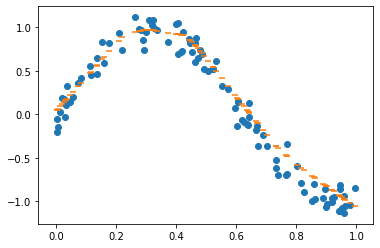

In [11]:
y_pred = model(x_tensor).to('cpu').data.numpy()
plt.scatter(x, y)
plt.scatter(x, y_pred, marker='_')

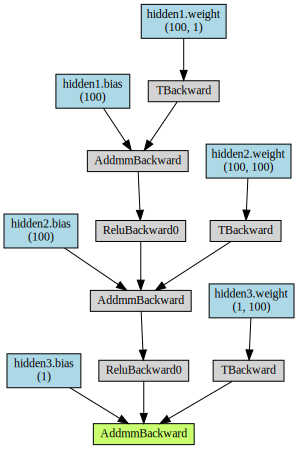

In [12]:
from torchviz import make_dot
y=model(x_tensor)
make_dot(y,params=dict(model.named_parameters()))

計算グラフの可視化

In [13]:
input_names = [ "input"]
output_names = [ "output" ]
torch.onnx.export(model, x_tensor, "./test_model.onnx", verbose=True,input_names=input_names,output_names=output_names)

graph(%input : Float(100, 1),
      %hidden1.weight : Float(100, 1),
      %hidden1.bias : Float(100),
      %hidden2.weight : Float(100, 100),
      %hidden2.bias : Float(100),
      %hidden3.weight : Float(1, 100),
      %hidden3.bias : Float(1)):
  %7 : Float(100, 100) = onnx::Gemm[alpha=1, beta=1, transB=1](%input, %hidden1.weight, %hidden1.bias) # C:\Users\keita\Anaconda3\envs\pytorch_dgl\lib\site-packages\torch\nn\functional.py:1370:0
  %8 : Float(100, 100) = onnx::Relu(%7) # C:\Users\keita\Anaconda3\envs\pytorch_dgl\lib\site-packages\torch\nn\functional.py:914:0
  %9 : Float(100, 100) = onnx::Gemm[alpha=1, beta=1, transB=1](%8, %hidden2.weight, %hidden2.bias) # C:\Users\keita\Anaconda3\envs\pytorch_dgl\lib\site-packages\torch\nn\functional.py:1370:0
  %10 : Float(100, 100) = onnx::Relu(%9) # C:\Users\keita\Anaconda3\envs\pytorch_dgl\lib\site-packages\torch\nn\functional.py:914:0
  %output : Float(100, 1) = onnx::Gemm[alpha=1, beta=1, transB=1](%10, %hidden3.weight, %hidden3.bias